In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator

#plot
import matplotlib.pyplot as plt
import seaborn as sns

!pip install --upgrade scipy

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import preprocessing_Origins,is_day,HenDailyVariable_Origins_simplest, is_WG_open, vertical_td_l
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


from scipy.stats import entropy
#less even possible
li = ['1_Zone','1_Zone','1_Zone','1_Zone','1_Zone','1_Zone','1_Zone']
x = li
print(entropy(list(Counter(list(x)).values()),base=2))
#most even possible
li = ['1_Zone',
      '2_Zone'
      '3_Zone',
      '4_Zone',
      '5_Zone']
x = li
print(entropy(list(Counter(list(x)).values()),base=2))
li = ['1_Zone',
      '3_Zone',
      '4_Zone']
x = li
print(entropy(list(Counter(list(x)).values()),base=2))
li = ['1_Zone','1_Zone','1_Zone','1_Zone','1_Zone','1_Zone',
      '3_Zone',
      '4_Zone','4_Zone','4_Zone','4_Zone','4_Zone','4_Zone']
x = li
print(entropy(list(Counter(list(x)).values()),base=2))
li = ['1_Zone','1_Zone','1_Zone','1_Zone',
      '4_Zone','4_Zone','4_Zone','4_Zone',
      '1_Zone','1_Zone',
      '4_Zone','4_Zone','4_Zone','4_Zone']
x = li
print(entropy(list(Counter(list(x)).values()),base=2))
li = ['1_Zone',
      '4_Zone']
x = li

# Define parameters

In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
date_consistent_barn_schedule = config.date_consistent_barn_schedule
print(id_run)
path_extracted_data_visual = os.path.join(path_extracted_data,'visual')
#create a director if not existing
if not os.path.exists(path_extracted_data_visual):
    os.makedirs(path_extracted_data_visual)

change the configuration file if not done yet!
ALLDATA_


In [4]:
path_extracted_data

'G:\\VPHI\\Welfare\\2- Research Projects\\OFHE2.OriginsE2\\DataOutput\\TrackingSystem\\ALLDATA_'

li_FR = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0]
print(len(li_FR))
fake_sec = -2
if fake_sec>0:
    li_FR =  list([0] * fake_sec)+li_FR[:-fake_sec]  
if fake_sec<0:
    li_FR =  li_FR[abs(fake_sec):] + list([0] * fake_sec)

print(len(li_FR))
li_FR

# Open records

In [5]:
#WARNING: we do it at seconds level, so the miliseconds from the general cleaning is not used!! 

In [6]:
df = pd.read_csv(os.path.join(path_extracted_data, id_run+'_CLEANEDDATA.csv'), sep=';', parse_dates=['Timestamp', 'date'],
                dayfirst=True) 
print(df.shape)
df.head(3)

(2681720, 18)


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,duration,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open,duration_mn,is_day
0,hen_1,pen9,8 - 9,2_Zone,1.0,2020-09-29 09:50:00,2020-09-29,2020-09-29 17:56:25,0 days 08:06:25,NaN,NaN,3_Zone,NaN,NaN,False,False,486.416667,True
1,hen_1,pen9,8 - 9,3_Zone,1.0,2020-09-29 17:56:25,2020-09-29,2020-09-30 09:55:59,0 days 02:52:35,2020-09-29 09:50:00,0 days 08:06:25,3_Zone,2_Zone,NaN,False,False,959.566667,False
2,hen_1,pen9,8 - 9,5_Zone,1.0,2020-09-30 09:55:59,2020-09-30,2020-09-30 11:34:30,0 days 01:32:11,2020-09-30 09:51:57,0 days 00:04:02,5_Zone,3_Zone,3_Zone,False,False,98.516667,True


# weather conditions just to look at

In [7]:
#weather conditions
path_weather = os.path.join(r'C:\Users\camil\Desktop\vm_exchange\PhD_Data\Weather_exp1','Weather_process.csv')
df_weather_h = pd.read_csv(path_weather, sep=';', parse_dates=['date','Timestamp'])
df_weather_h = df_weather_h.sort_values('Timestamp') 
df_weather_h = df_weather_h.drop(['date'], axis=1)
df_weather_h['Timestamp_weather'] = df_weather_h['Timestamp'].copy()
df_weather_h['date'] = df_weather_h['Timestamp'].map(lambda x:  dt.datetime.date(x))
print(df_weather_h.shape)
display(df_weather_h.head(3))

(7293, 14)


,Timestamp,temperature,humidity,wind speed,Precipitation amount,query,Moon Phase calculator,hour,temperature_C,wind_speed_mpers,humidity_avgpercent,rain,Timestamp_weather,date
0,2020-09-29 00:00:00,"10 °C\n(12:00 am CEST | Tuesday, September 29,...",average: 100% (100%)\n(12:00 am CEST | Tuesday...,"2 m/s\n(12:00 am CEST | Tuesday, September 29,...","rain\n(12:00 am CEST | Tuesday, September 29, ...","Moon Phase calculatorSeptember 29, 2020 0h",| waxing gibbous moon\n91.87% illuminated,0,10,2,100,rain,2020-09-29 00:00:00,2020-09-29
1,2020-09-29 01:00:00,"10 °C\n(1:00 am CEST | Tuesday, September 29, ...","average: 100% (100%)\n(1:00 am CEST | Tuesday,...","3 m/s\n(1:00 am CEST | Tuesday, September 29, ...","rain\n(1:00 am CEST | Tuesday, September 29, 2...","Moon Phase calculatorSeptember 29, 2020 1h",| waxing gibbous moon\n92.09% illuminated,1,10,3,100,rain,2020-09-29 01:00:00,2020-09-29
2,2020-09-29 02:00:00,"10 °C\n(2:00 am CEST | Tuesday, September 29, ...","average: 100% (100%)\n(2:00 am CEST | Tuesday,...","3 m/s\n(2:00 am CEST | Tuesday, September 29, ...","rain\n(2:00 am CEST | Tuesday, September 29, 2...","Moon Phase calculatorSeptember 29, 2020 2h",| waxing gibbous moon\n92.30% illuminated,2,10,3,100,rain,2020-09-29 02:00:00,2020-09-29


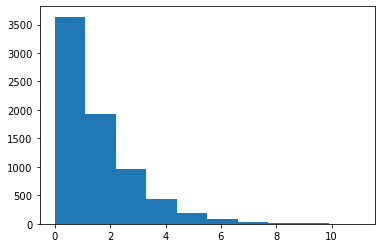

In [8]:
plt.hist(df_weather_h['wind_speed_mpers']);

,Timestamp,temperature,humidity,wind speed,Precipitation amount,query,Moon Phase calculator,hour,temperature_C,wind_speed_mpers,humidity_avgpercent,rain,Timestamp_weather,date
4236,2021-03-26 00:00:00,"4 °C\n(12:00 am CET | Friday, March 26, 2021)","average: 100% (100%)\n(12:00 am CET | Friday, ...","1 m/s\n(12:00 am CET | Friday, March 26, 2021)","no precipitation\n(12:00 am CET | Friday, Marc...","Moon Phase calculatorMarch 26, 2021 0h",| waxing gibbous moon\n89.26% illuminated,0,4,1,100,no precipitation,2021-03-26 00:00:00,2021-03-26
4237,2021-03-26 01:00:00,"4 °C\n(1:00 am CET | Friday, March 26, 2021)","average: 100% (100%)\n(1:00 am CET | Friday, M...","0 m/s\n(1:00 am CET | Friday, March 26, 2021)","no precipitation\n(1:00 am CET | Friday, March...","Moon Phase calculatorMarch 26, 2021 1h",| waxing gibbous moon\n89.55% illuminated,1,4,0,100,no precipitation,2021-03-26 01:00:00,2021-03-26
4238,2021-03-26 02:00:00,"3 °C\n(2:00 am CET | Friday, March 26, 2021)","average: 100% (100%)\n(2:00 am CET | Friday, M...","0 m/s\n(2:00 am CET | Friday, March 26, 2021)","no precipitation\n(2:00 am CET | Friday, March...","Moon Phase calculatorMarch 26, 2021 2h",| waxing gibbous moon\n89.83% illuminated,2,3,0,100,no precipitation,2021-03-26 02:00:00,2021-03-26


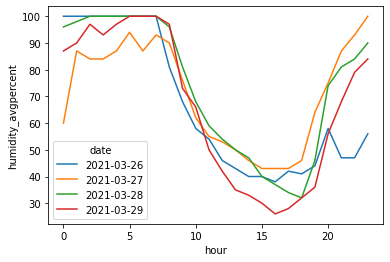

In [9]:
df_plt = df_weather_h[(df_weather_h['date']<dt.datetime.date(dt.datetime(2021,3,30)))&\
             (df_weather_h['date']>dt.datetime.date(dt.datetime(2021,3,25)))]
display(df_plt.head(3))
sns.lineplot(y='humidity_avgpercent', x='hour', hue='date', data=df_plt);

In [10]:
print(df_weather_h[df_weather_h['wind_speed_mpers']==0].shape,
      df_weather_h[df_weather_h['wind_speed_mpers']==1].shape,
      df_weather_h[df_weather_h['wind_speed_mpers']>1].shape)

(648, 14) (2989, 14) (3656, 14)


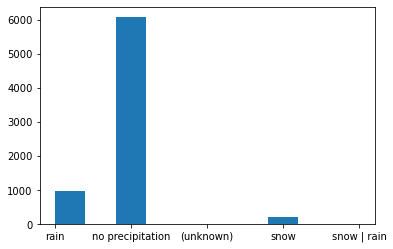

In [11]:
plt.hist(df_weather_h['rain']);

# Compute variables

In [12]:
#open time series per session and compute the variables for each session (car time series make sence at session level), et en 
#plus des variables tel que running entropy over the whole session ateach last timestamp of each level make sence only at 
#session level
#once to much data, do this per pen!!! with name=pens!!
START_TIME = time.perf_counter()
li_pen = list(df['PenID'].unique())
#li_pen.reverse()
li_pe = ['pen5']
for p in tqdm.tqdm(li_pen):
    print(p)
    #&(df['date']>date_consistent_barn_schedule)&(df['date']<dt.datetime(2020,11,30))
    #&(df['date']>dt.datetime(2021,3,5))&(df['date']<dt.datetime(2021,4,25))
    df_daily = HenDailyVariable_Origins_simplest(df[df['PenID']==p], config, name_=p, timestamp_name='Timestamp', 
                                        has_cons_equal_zone=False, save=True)
    print(df_daily.shape)
    display(df_daily.head(3))
    print(df_daily['level'].min())
END_TIME = time.perf_counter()
print ("Total running time: %.2f mn" %((END_TIME-START_TIME)/60))  

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

pen9


C:\Users\camil\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\camil\Desktop\animals_code\PhD-AnimalWelfare\UTILS.py:3384: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[timestamp_name] = df[timestamp_name].map(lambda x: dt.datetime(x.year,x.month,x.day,x.hour,x.minute, x.second))


----------------- Create time serie
in this time series there is 28 hens
The initial starting date in over all is: 2020-09-29 09:36:51, and the ending date will be: 2021-07-25 23:53:11
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2020-09-29 09:36:51, and the ending date will be: 2021-07-25 23:59:59
Total running time: 7.04 mn
your time series has 1 seconds between two timestamps
----------------- main night zone and nbr of transitions over night....
----------------- total & percentage duration per Zone in seconds....
----------------- first timestamp in each zone per day & latency var....
----------------- number of Zone (excluding nan)....
----------------- compute some variables based on a list of zones over a day....
------------ add WG info
------------ add hen basics info
From the focalBirdinfo, you have 154 ative tags
(7563, 59)
(5941, 61)
-------------- Let

All the night variables are:  Index(['HenID', 'night_level', 'night_Max_duration_zones', 'night_duration_Z5',
       'night_Total_number_transition', 'is_mvt_night', 'level', 'PenID',
       'CLASS', 'R-Pen', 'InitialStartDate', 'early_death', 'Treatment'],
      dtype='object')
['night_level']
-------------- Lets remove dates of tags when they were not giving deviceupdate correctly


-------------- Lets remove the 30.09.2020 for the tags that still had no transition from before the light went on 


-------------- Lets remove all (dates,tagid) with not all seconds tracked (e.g. first day an animal is tracked), and no night variable


-------------- remove days with only the night and not the days variables, as due to flickering we wont really use night


-------------- Lets remove all above the last official tracked day


save
Total running time: 110.30 mn
(5029, 70)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,night_Max_duration_zones,night_duration_Z5,night_Total_number_transition,is_mvt_night,nbr_h_per_day,correct_amount_of_hour,DOA,WOA,DIB,WIB
1,hen_1,2020-09-30,NaN,18886.0,3488.0,515.0,5911.0,28800.0,8.0,"[0.0, 18886.0, 3488.0, 515.0, 5911.0]",...,5_Zone,54466.0,3.0,1.0,8,True,119,17,1,1
2,hen_1,2020-10-01,NaN,9310.0,5636.0,0.0,17454.0,32400.0,9.0,"[0.0, 9310.0, 5636.0, 0.0, 17454.0]",...,5_Zone,54000.0,0.0,0.0,9,True,120,18,2,1
3,hen_1,2020-10-02,NaN,0.0,551.0,0.0,31849.0,32400.0,9.0,"[0.0, 0.0, 551.0, 0.0, 31849.0]",...,5_Zone,54000.0,0.0,0.0,9,True,121,18,3,1


 12%|█████████▋                                                                   | 1/8 [1:50:35<12:54:07, 6635.42s/it]

2020-09-30 00:00:00
pen11


C:\Users\camil\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\camil\Desktop\animals_code\PhD-AnimalWelfare\UTILS.py:3384: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[timestamp_name] = df[timestamp_name].map(lambda x: dt.datetime(x.year,x.month,x.day,x.hour,x.minute, x.second))


----------------- Create time serie
in this time series there is 28 hens
The initial starting date in over all is: 2020-09-29 09:08:12, and the ending date will be: 2021-07-25 22:58:37
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2020-09-29 09:08:12, and the ending date will be: 2021-07-25 23:59:59


 12%|█████████▋                                                                   | 1/8 [1:57:27<13:42:14, 7047.82s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\camil\AppData\Local\Temp/ipykernel_23456/3101012645.py", line 13, in <module>
    df_daily = HenDailyVariable_Origins_simplest(df[df['PenID']==p], config, name_=p, timestamp_name='Timestamp',
  File "C:\Users\camil\Desktop\animals_code\PhD-AnimalWelfare\UTILS.py", line 3393, in HenDailyVariable_Origins_simplest
    df_ts = time_series_henColumn_tsRow(df, config, col_ts='Zone', ts_with_all_hen_value=False, save=False, hen_time_series=False)
  File "C:\Users\camil\Desktop\animals_code\PhD-AnimalWelfare\UTILS.py", line 632, in time_series_henColumn_tsRow
    df_hens['date'] = df_hens['Timestamp'].map(lambda x: dt.datetime(x.year,x.month,x.day))
  File "C:\Users\camil\anaconda3\lib\site-packages\pandas\core\series.py", line 4162, in map
    return self._constructor(new_values, i

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\camil\AppData\Local\Temp/ipykernel_23456/3101012645.py", line 13, in <module>
    df_daily = HenDailyVariable_Origins_simplest(df[df['PenID']==p], config, name_=p, timestamp_name='Timestamp',
  File "C:\Users\camil\Desktop\animals_code\PhD-AnimalWelfare\UTILS.py", line 3393, in HenDailyVariable_Origins_simplest
    df_ts = time_series_henColumn_tsRow(df, config, col_ts='Zone', ts_with_all_hen_value=False, save=False, hen_time_series=False)
  File "C:\Users\camil\Desktop\animals_code\PhD-AnimalWelfare\UTILS.py", line 632, in time_series_henColumn_tsRow
    df_hens['date'] = df_hens['Timestamp'].map(lambda x: dt.datetime(x.year,x.month,x.day))
  File "C:\Users\camil\anaconda3\lib\site-packages\pandas\core\series.py", line 4162, in map
    return self._constructor(new_values, i

TypeError: object of type 'NoneType' has no len()

In [13]:
#Concatenate all HenVariables csv into one
li_paths_var = glob.glob(os.path.join(path_extracted_data, id_run+'_daily__pen'+'*_variables.csv'))
li_df = []
if len(li_paths_var)!=8:
    print('ERROR: not the correct number of files, there must have one per pen')
    sys.exit()
for path_var in tqdm.tqdm(li_paths_var):
    #for being more reproductible, we open the file that was saved from cleaning
    df_ = pd.read_csv(path_var, sep=';',parse_dates=['level', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 
                                                     'FirstTimestamp_3_Zone','FirstTimestamp_4_Zone',
                                                     'FirstTimestamp_5_Zone']) 
    print(df_.shape)
    li_df.append(df_)
df_daily = pd.concat(li_df)
df_daily.to_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables.csv'), sep=';', index=False)
print(df_daily.shape)
df_daily.head(3)

ERROR! Session/line number was not unique in database. History logging moved to new session 3073


 12%|██████████▌                                                                         | 1/8 [01:33<10:57, 93.89s/it]

(5049, 70)


 25%|█████████████████████                                                               | 2/8 [03:11<09:35, 95.84s/it]

(5041, 70)


 38%|███████████████████████████████▌                                                    | 3/8 [04:37<07:38, 91.62s/it]

(4757, 70)


 50%|██████████████████████████████████████████                                          | 4/8 [05:52<05:39, 84.91s/it]

(4170, 70)


 62%|████████████████████████████████████████████████████▌                               | 5/8 [07:23<04:21, 87.20s/it]

(4926, 70)


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [08:54<02:56, 88.41s/it]

(5000, 67)


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [10:21<01:27, 87.89s/it]

(4742, 70)


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [11:50<00:00, 88.84s/it]

(5029, 70)


(38714, 70)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,night_Max_duration_zones,night_duration_Z5,night_Total_number_transition,is_mvt_night,nbr_h_per_day,correct_amount_of_hour,DOA,WOA,DIB,WIB
0,hen_130,2020-10-05,NaN,0.0,0.0,0.0,32400.0,32400.0,9.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]",...,5_Zone,54000.0,0.0,0.0,9,True,124,18,6,1
1,hen_130,2020-10-06,NaN,0.0,780.0,325.0,31295.0,32400.0,9.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]",...,3_Zone,5363.0,1.0,1.0,9,True,125,18,7,1
2,hen_130,2020-10-07,NaN,206.0,249.0,130.0,31815.0,32400.0,9.0,"[0.0, 206.0, 249.0, 130.0, 31815.0]",...,5_Zone,54000.0,0.0,0.0,9,True,126,18,8,2


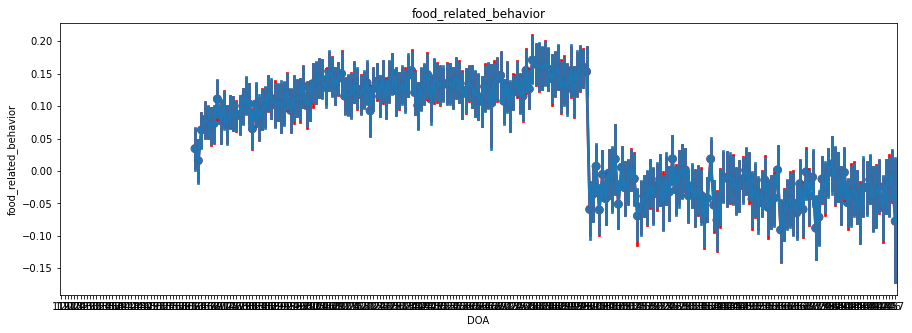

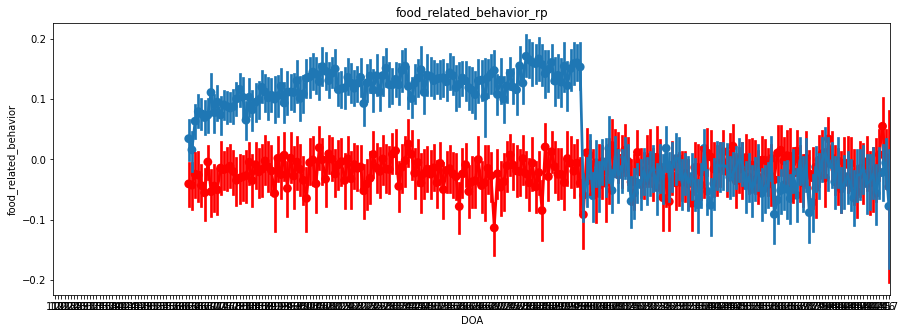

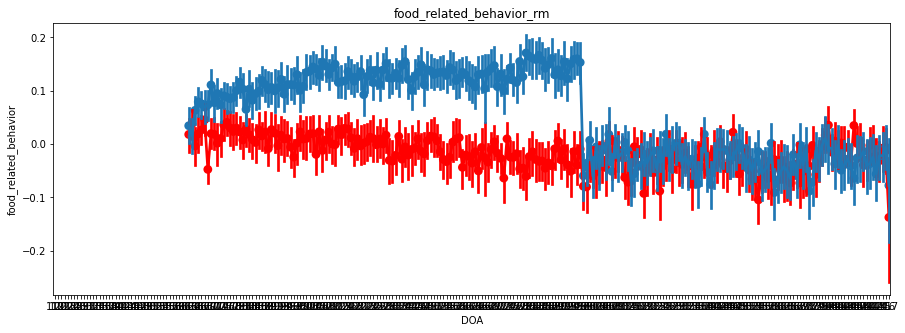

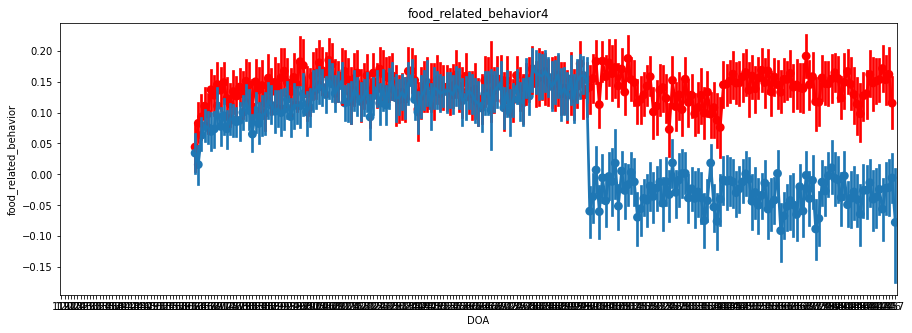

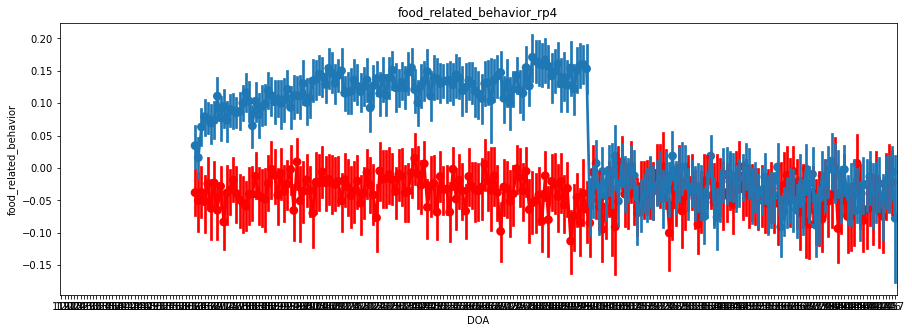

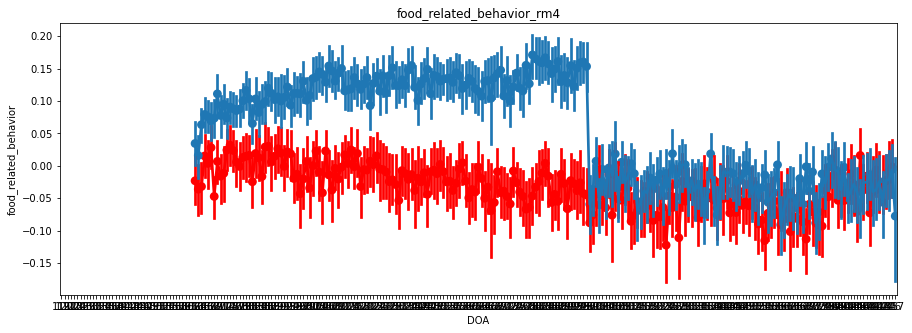

In [14]:
li_food = [i for i in df_daily.columns if 'food_related' in i]
li_food
for b in li_food:
    plt.figure(figsize=(15,5))
    sns.pointplot(y=b, x='DOA', color='red', data=df_daily);
    sns.pointplot(y='food_related_behavior', x='DOA',  data=df_daily);
    plt.title(b)
    plt.show();

In [15]:
display(list(df_daily.columns))

['HenID',
 'level',
 'duration_1_Zone',
 'duration_2_Zone',
 'duration_3_Zone',
 'duration_4_Zone',
 'duration_5_Zone',
 'verification_daily_total_duration',
 'verification_daily_total_nbr_hour',
 'dur_values',
 'dur_values_normalized',
 'perc_duration_3_Zone',
 'perc_duration_4_Zone',
 'perc_duration_5_Zone',
 'perc_duration_2_Zone',
 'perc_duration_1_Zone',
 'time_wg_open_sec',
 'duration_sincedaystarted_beforeWGopened_sec',
 'perc_1_Zone_while_WG_open',
 'FirstTimestamp_1_Zone',
 'FirstTimestamp_2_Zone',
 'FirstTimestamp_3_Zone',
 'FirstTimestamp_4_Zone',
 'FirstTimestamp_5_Zone',
 'nbr_h_WGopen',
 'FirstTimestamp_1_Zone_sec',
 'latency_1_Zone_h',
 'Total_number_zone',
 'list_of_durations',
 'food_related_behavior',
 'food_related_behavior_rp',
 'food_related_behavior_rm',
 'food_related_behavior4',
 'food_related_behavior_rp4',
 'food_related_behavior_rm4',
 'nestboxes_related_behavior',
 'list_of_zones',
 'list_Z4',
 'mid_cum_Z4_sec',
 'Total_number_transition',
 'nbr_stays',
 'di

In [16]:
df_daily['level'].min()

Timestamp('2020-09-30 00:00:00')

# Chi2distance

#computed here as its a variable and not a visual computed out of variable
#compute for every level a symmetric chi2distance heatmap
if compute_chi2_distance:   

    #sort by lowest entropy (i.e. need less info to predict futur. more predictibale should induce more similarities 
    #(as less different solution)), to potentialy make a nicer visual
    df_ = df_daily.groupby(['HenID'])['distribution_entropy'].agg(lambda x:np.mean(x)).reset_index().sort_values(['distribution_entropy'])
    li = df_['HenID'].tolist()
    axis_label = [i.split('_')[1] for i in li]
    #create path to save visual if not existing
    path_ = os.path.join(path_extracted_data,'visual','chi2distance')
    #create a director if not existing
    if not os.path.exists(path_):
        os.makedirs(path_)

    print('----------------- Compute Chi2 distance....')
    for d in li_date:
        M = np.zeros(shape=(len(li),len(li)))
        for i, h1 in enumerate(li[:-1]):
            for j in range(i+1,len(li)):
                h2 = li[j]
                li_hen_in = df_daily[df_daily['level']==d]['HenID'].unique()
                #if both hen have at least one record this day (typically not always all hen have values the first day of session)
                if (h1 in li_hen_in) & (h2 in li_hen_in):
                    l1 = df_daily[(df_daily['HenID']==h1)&(df_daily['level']==d)]['dur_values_normalized'].values[0]
                    l2 = df_daily[(df_daily['HenID']==h2)&(df_daily['level']==d)]['dur_values_normalized'].values[0]
                    chi2 = chi2_distance(l1,l2)
                    M[i][j] = chi2
                    M[j][i] = chi2
        #clear old plot
        plt.figure()
        sns.set(font_scale=0.25) 
        sns.heatmap(M, cmap="YlGnBu", xticklabels=axis_label, yticklabels=axis_label)
        plt.title(d)
        if save:
            plt.savefig(os.path.join(path_,id_run+'_chi2distance_'+str(d).split('T')[0]+'_daily_'+'.png'), dpi=300,
                        format='png',bbox_inches='tight')
        #plt.show() 
        plt.close()

